In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D
from fenics import *
from mshr import *
import numpy as np
from dotenv import load_dotenv
from scipy.ndimage import zoom
import os

# Cargar las variables del archivo .env
load_dotenv()

True

In [7]:
nueva_ruta = '/media/erick/TOSHIBA EXT/pruebas_mu_cero'

In [8]:
# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = int(os.getenv('nb'))
save_images = os.getenv('SAVE_IMAGES')

# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = int(os.getenv('nb'))

os.chdir(nueva_ruta)


mu=1## Transformada de Fourier

##### La transformada de Fourier se utiliza para analizar la frecuencia espacial de los patrones en los campos de concentración de las especies. Este análisis puede revelar información sobre la estructura y distribución espacial de las células en el dominio.

##### Frecuencias Altas: Indicarían cambios abruptos en la concentración de células, lo que podría asociarse con la formación de límites nítidos entre las especies (por ejemplo, la frontera entre un tumor y el tejido sano).

##### Frecuencias Bajas: Indicarían una distribución más homogénea de las células, lo que podría reflejar una invasión difusa del tumor o una respuesta inmune uniforme.


## Espectro de Potencia

### Frecuencias Espaciales:

##### Frecuencias Bajas (cerca del centro del espectro de potencia): Estas frecuencias corresponden a estructuras grandes o variaciones suaves en la distribución espacial. En un contexto biológico, esto podría estar asociado con regiones grandes de concentración uniforme de células, como una masa tumoral homogénea.

##### Frecuencias Altas (alejadas del centro del espectro de potencia): Estas frecuencias corresponden a estructuras pequeñas o variaciones abruptas en la distribución espacial, como los bordes afilados de un tumor o pequeños grupos de células.


### Amplitud en el Espectro de Potencia:

##### La magnitud de los valores en el espectro de potencia te indica cuánta energía está presente en cada frecuencia. Si hay un pico en una frecuencia específica, sugiere que hay un patrón espacial dominante con esa frecuencia en la distribución celular.

##### Por ejemplo, un pico en una frecuencia baja podría indicar que el campo tiene una estructura general 




## Función power_spectrum(field_type, t, block)


### Cálculo del Espectro de Fourier:


##### Esta función calcula la Transformada Rápida de Fourier (FFT) de un campo espacial correspondiente a una especie dada (field_type) en un tiempo t para un bloque respectivo de la simulación.

##### La FFT se centra utilizando fftshift, y luego se calcula el valor absoluto de la FFT, que representa la magnitud del espectro de potencia.

##### El valor máximo del espectro se pone a cero para eliminar el componente de baja frecuencia (frecuencia cero)

In [4]:
def power_spectrum(field_type, t, block):
    field_file = "matrix_"  + field_type +"_"+ "{:.3f}".format(t) + "_" + "nb_" + str(block) + ".txt"
    field=np.loadtxt(field_file,float)
    field = np.rot90(field, k=1, axes=(0, 1))
    fft_field = np.fft.fft2(field)
    fft_field=np.fft.fftshift(fft_field)
    fft_field=(np.abs(fft_field))
    max_fft = np.where(fft_field == fft_field.max())
    fft_field[max_fft[0][0],max_fft[1][0]] = 0
    dft_file = "matrix" + "_{}_dft_".format(field_type) + "{:.3f}".format(t) + "_" + "nb_" + str(block) + ".txt"
    np.savetxt(dft_file, fft_field, delimiter="\t")
    return field_file, dft_file

## Función dft_mean(field, end_step, end_blocks, dt)

##### El promedio temporal del espectro de potencia te permite evaluar cómo evoluciona el patrón espacial dominante en el tiempo. Un cambio en el espectro promedio podría indicar cambios en la dinámica del tumor o en la respuesta inmune.

### Promedio del Espectro de Fourier:

##### Esta función calcula el promedio de los espectros de Fourier para una especie dada (field) a lo largo de múltiples bloques de simulación. Este promedio reduce el ruido estadístico y resalta las características globales del espectro.

### Visualización del Espectro Promedio:

##### Al final de la función, se muestra y guarda el espectro de Fourier promedio. Este gráfico permite observar la estructura espacial media de las células en el tiempo, proporcionando una visión más clara de las características dominantes en la distribución celular.


### Promedio Polar y Longitud de Correlación
##### El promedio polar te da una medida de la longitud de correlación, que indica la distancia típica a la cual dos puntos en el campo están correlacionados.

##### Esto puede ser útil para identificar la escala espacial a la que ocurre la organización celular, como el tamaño típico de los clusters de células.


In [11]:
def dft_mean(field, end_step, end_blocks, dt):
    t0 = 0
    min_shape = None
    
    while t0 <= end_step:
        t0 += dt
        # print('step', t0)
        final_file = None
        
        for nb in range(1, end_blocks + 1):
            file_name = "matrix_" + field + "_dft_" + "{:.3f}".format(t0) + "_nb_" + str(nb) + ".txt"
            file_load = np.loadtxt(file_name, float)
            
            if final_file is None:
                final_file = file_load
                min_shape = file_load.shape
            else:
                min_shape = (min(min_shape[0], file_load.shape[0]), min(min_shape[1], file_load.shape[1]))
        
        # Redimensionar final_file y file_load a min_shape
        final_file_cropped = final_file[:min_shape[0], :min_shape[1]]
        final_file = np.zeros(min_shape)  # Re-inicializar final_file al tamaño mínimo
        
        for nb in range(1, end_blocks + 1):
            file_name = "matrix_" + field + "_dft_" + "{:.3f}".format(t0) + "_nb_" + str(nb) + ".txt"
            file_load = np.loadtxt(file_name, float)
            file_load_cropped = file_load[:min_shape[0], :min_shape[1]]
            final_file += file_load_cropped
        
        final_file = final_file / float(end_blocks)
        
        f_save = "FFT_" + field + "_" + "{:.3f}".format(t0) + ".txt"
        np.savetxt(f_save, final_file, delimiter="\t")
        
        # plt.imshow(final_file, cmap=plt.cm.seismic)
        # plt.title(f'Mean_fft_{field}_(t={t0:.3f})')
        # plt.colorbar()
        # if save_images == 'Y':
        #     plt.savefig(f'mean_fft_block_{field}_{nb}_step_{t0:.3f}.png')
        #     plt.show()
        # else:
        #     plt.show()

In [1]:
def plot_fft(dft_field_c, dft_field_s, dft_field_i, t, save_images, block): 

    dft_field_c = np.loadtxt(dft_field_c, float)
    dft_field_c[dft_field_c == 0.0] = np.nan
    dft_field_s = np.loadtxt(dft_field_s, float)
    dft_field_s[dft_field_s == 0.0] = np.nan
    dft_field_i = np.loadtxt(dft_field_i, float)
    dft_field_i[dft_field_i == 0.0] = np.nan   
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(1, 3, 1)
    img1 = plt.imshow(dft_field_c, cmap='seismic', interpolation='bilinear')
    plt.title("$fft_c(t={})$".format("{:.3f}".format(t)))
    plt.colorbar(img1, fraction=0.046, pad=0.04)  # Ajusta fraction y pad
    
    plt.subplot(1, 3, 2)
    img2 = plt.imshow(dft_field_s, cmap='seismic', interpolation='bilinear')
    plt.title("$fft_s(t={})$".format("{:.3f}".format(t)))
    plt.colorbar(img2, fraction=0.046, pad=0.04)  # Ajusta fraction y pad
    
    plt.subplot(1, 3, 3)
    img3 = plt.imshow(dft_field_i, cmap='seismic', interpolation='bilinear')
    plt.title("$fft_i(t={})$".format("{:.3f}".format(t)))
    plt.colorbar(img3, fraction=0.046, pad=0.04)  # Ajusta fraction y pad
    
    if save_images == 'Y':
        plt.savefig(f'FFT_block_{block}_step_{t:.3f}.png')
        plt.show()
        pass
    else:
        plt.show()
        pass

In [2]:
for block in range(1,nb+1):
    t = 0
    print("block=", block)  
    while t <= T:
        t += dt
        field_c, dft_field_c = power_spectrum('c', t, block)
        field_s, dft_field_s = power_spectrum('s', t, block)
        field_i, dft_field_i = power_spectrum('i', t, block)     
        plot_fft(dft_field_c, dft_field_s, dft_field_i, t, save_images, block)



NameError: name 'nb' is not defined

In [12]:
dft_mean('c', T, nb, dt)

In [13]:
dft_mean('s', T, nb, dt)

In [14]:
dft_mean('i', T, nb, dt)


mu=1
mu=1### Autocorrelación Espacial (correlaciones cc, ss, ii):

##### La autocorrelación te indica cómo las células de un mismo tipo se distribuyen en el espacio. Por ejemplo, si la autocorrelación de c muestra un valor alto en distancias pequeñas, significa que las células cancerígenas tienden a agruparse o formar clusters.

##### La evolución de la autocorrelación en el tiempo te puede indicar cómo cambian estas agrupaciones celulares a medida que avanza el tiempo.

##### cc, ss, ii: Representan las correlaciones autointernas (o autocorrelaciones) para cada una de las especies (células cancerosas, sanas e inmunitarias). Estos valores indican cómo una especie se correlaciona consigo misma en el espacio, y pueden darte información sobre la homogeneidad o la dispersión espacial de las células en cuestión.


### Correlación Cruzada (correlaciones cs, ci, si):

##### La correlación cruzada entre diferentes tipos de células te indica cómo se relacionan espacialmente. Por ejemplo, una alta correlación cruzada entre c y i podría sugerir que las células inmunitarias tienden a agruparse alrededor de las células cancerígenas.

##### cs, sc: Estas son las correlaciones cruzadas entre células cancerosas y sanas. Analizar estos términos puede darte información sobre cómo las células cancerosas influyen en la distribución de las células sanas o viceversa. Una alta correlación positiva podría indicar que las células sanas y las células cancerosas tienden a coexistir en las mismas regiones, mientras que una correlación negativa podría sugerir que las células cancerosas desplazan a las células sanas.

##### ci, ic: Estas correlaciones cruzadas entre células cancerosas e inmunitarias pueden revelar la efectividad de la respuesta inmunitaria contra las células cancerosas. Una correlación positiva alta podría sugerir que las células inmunitarias están respondiendo bien a la presencia de células cancerosas, mientras que una correlación negativa podría indicar que las células cancerosas están evadiendo la respuesta inmunitaria.

##### si, is: Estas correlaciones cruzadas entre células sanas e inmunitarias pueden ofrecer insights sobre la protección que las células inmunitarias brindan a las células sanas o sobre cómo estas dos poblaciones celulares interactúan en presencia de una enfermedad.

In [16]:
def resize_to_shape(arr, shape):
    zoom_factors = (shape[0] / arr.shape[0], shape[1] / arr.shape[1])
    return zoom(arr, zoom_factors, order=1) 

## Función correlation_2D(step)

##### Se cargan los espectros de potencia para las tres especies en un instante de tiempo dado (step).


### Transformada Inversa de Fourier:
##### Para cada especie, se calcula la transformada inversa del espectro de potencia al cuadrado. Esto da como resultado la función de autocorrelación espacial 2D, que indica cómo una propiedad se correlaciona consigo misma a diferentes distancias en el espacio.

##### También se calcula la correlación cruzada entre pares de especies (c-s, c-i, s-i), lo que indica la relación espacial entre diferentes tipos de células.

### Cálculo de la Correlación Normalizada:

##### Se normalizan las funciones de autocorrelación y correlación cruzada, restando la media y dividiendo por la desviación estándar. Esto permite obtener una medida de la correlación que es independiente de las unidades y magnitudes absolutas de los campos.


In [9]:
def correlation_2D(step):
    #obten el módulo del promedio del espectro de potencias
    abs_c = "FFT_" + "c_" + "{:.3f}".format(step) + ".txt"
    abs_s = "FFT_" + "s_" + "{:.3f}".format(step) + ".txt"
    abs_i = "FFT_" + "i_" + "{:.3f}".format(step) + ".txt"
    
    mod_c = np.loadtxt(abs_c, float)
    mod_s = np.loadtxt(abs_s, float)
    mod_i = np.loadtxt(abs_i, float)
    
    # Determinar el tamaño máximo
    max_shape = (max(mod_c.shape[0], mod_s.shape[0], mod_i.shape[0]),
                 max(mod_c.shape[1], mod_s.shape[1], mod_i.shape[1]))
    
    # Redimensionar todas las matrices al tamaño máximo
    mod_c = resize_to_shape(mod_c, max_shape)
    mod_s = resize_to_shape(mod_s, max_shape)
    mod_i = resize_to_shape(mod_i, max_shape)
    
    # calcula la inversa del modulo al cuadrado
    c2_inv = np.fft.ifftn(mod_c**2)
    max_fft_c2_inv = np.where(c2_inv == c2_inv.max())
    c2_inv[max_fft_c2_inv[0][0],max_fft_c2_inv[1][0]] = 0   
    
    s2_inv = np.fft.ifftn(mod_s**2)
    max_fft_s2_inv = np.where(s2_inv == s2_inv.max())
    s2_inv[max_fft_s2_inv[0][0],max_fft_s2_inv[1][0]] = 0

    i2_inv = np.fft.ifftn(mod_i**2)
    max_fft_i2_inv = np.where(i2_inv == i2_inv.max())
    i2_inv[max_fft_i2_inv[0][0],max_fft_i2_inv[1][0]] = 0
    

    cs_inv = np.fft.ifftn(mod_c*mod_s)
    max_fft_cs_inv = np.where(cs_inv == cs_inv.max())
    cs_inv[max_fft_cs_inv[0][0],max_fft_cs_inv[1][0]] = 0
    
    ci_inv = np.fft.ifftn(mod_c*mod_i)
    max_fft_ci_inv = np.where(ci_inv == ci_inv.max())
    ci_inv[max_fft_ci_inv[0][0],max_fft_ci_inv[1][0]] = 0
    
    si_inv = np.fft.ifftn(mod_s*mod_i)
    max_fft_si_inv = np.where(si_inv == si_inv.max())
    si_inv[max_fft_si_inv[0][0],max_fft_si_inv[1][0]] = 0
 
    #Desplace el componente de frecuencia cero al centro del espectro.
    c2_inv = np.fft.fftshift(c2_inv)
    s2_inv = np.fft.fftshift(s2_inv)
    i2_inv = np.fft.fftshift(i2_inv)
    cs_inv = np.fft.fftshift(cs_inv)
    ci_inv = np.fft.fftshift(ci_inv)
    si_inv = np.fft.fftshift(si_inv)

    # Obten el valor absoluto de la tranformada inversa
    file_abs_c  = np.abs(c2_inv)
    file_abs_s  = np.abs(s2_inv)
    file_abs_i  = np.abs(i2_inv)

    file_abs_cs = np.abs(cs_inv)
    file_abs_ci = np.abs(ci_inv)
    file_abs_si = np.abs(si_inv)
 

    mean_c = np.mean(file_abs_c)
    mean_s = np.mean(file_abs_s)
    mean_i = np.mean(file_abs_i)
    
    std_c = np.std(mod_c)
    std_s =  np.std(mod_s)
    std_i =  np.std(mod_i)
    
    #Calcula las correlaciones
    corr_cc = (file_abs_c - mean_c**2) / (std_c*std_c)
    corr_ss = (file_abs_s - mean_s**2) / (std_s*std_s)
    corr_ii = (file_abs_i - mean_i**2) / (std_i*std_i)

    
    corr_cs = (file_abs_cs - mean_c*mean_s) / (std_c*std_s)
    corr_ci = (file_abs_ci - mean_c*mean_i) / (std_c*std_i)
    corr_si = (file_abs_si - mean_s*mean_i) / (std_s*std_i)

    
    matrix_corr_cc_file = "matrix_corr" + "_cc_" + "{:.3f}".format(step) + ".txt"
    np.savetxt(matrix_corr_cc_file, corr_cc, delimiter="\t")
    matrix_corr_ss_file = "matrix_corr" + "_ss_" + "{:.3f}".format(step) + ".txt"
    np.savetxt(matrix_corr_ss_file, corr_ss, delimiter="\t")
    matrix_corr_ii_file = "matrix_corr" + "_ii_" + "{:.3f}".format(step) + ".txt"
    np.savetxt(matrix_corr_ii_file, corr_ii, delimiter="\t")
    matrix_corr_cs_file = "matrix_corr" + "_cs_" + "{:.3f}".format(step) + ".txt"
    np.savetxt(matrix_corr_cs_file, corr_cs, delimiter="\t")
    matrix_corr_ci_file = "matrix_corr" + "_ci_" + "{:.3f}".format(step) + ".txt"
    np.savetxt(matrix_corr_ci_file, corr_ci, delimiter="\t")
    matrix_corr_si_file = "matrix_corr" + "_si_" + "{:.3f}".format(step) + ".txt"
    np.savetxt(matrix_corr_si_file, corr_si, delimiter="\t")

    return None

## Función polar_mean(step, corr_type)
##### Esta función toma una de las correlaciones calculadas (cc, ss, ii, cs, ci, si) y promedia sus valores a lo largo de diferentes ángulos en el espacio polar. Esto da una medida de la correlación como función de la distancia, sin tener en cuenta la dirección.

##### El promedio polar te da una medida de la longitud de correlación, que indica la distancia típica a la cual dos puntos en el campo están correlacionados.

##### Esto puede ser útil para identificar la escala espacial a la que ocurre la organización celular, como el tamaño típico de los clusters de células.


In [10]:
def polar_mean(step, corr_type):
    matrix_file = "matrix_corr_" + corr_type + "_" + "{:.3f}".format(step) + ".txt"
    matrix = np.loadtxt(matrix_file, float)
    n = len(matrix)  
    dk = 1.0
    p = np.zeros(int(n/2))
    for i in range(1,int(n/2)): 
        k = dk*i
        suma = 0.
        dtheta = np.pi/90. # two degrees

        for j in range (1,180):
            theta = j * dtheta    
            nx = int(k*np.cos(theta)/dk - n/2)
            ny = int(k*np.sin(theta)/dk - n/2)
            suma += matrix[nx,ny]        
        p[i] = suma/180.

    filename = "correlation_" + corr_type + "_" + "{:.3f}".format(step) + ".txt"         
    np.savetxt(filename, p, delimiter="\n")
    return None

In [11]:
def axis_mean(step, corr_type):
    # Redondea el valor de `step` a 3 decimales
    step_rounded = round(step, 3)
    
    # Ajusta el nombre del archivo con el valor redondeado
    matrix_file = "matrix_corr_" + corr_type + "_" + "{:.3f}".format(step_rounded) + ".txt"
    
    try:
        # Intenta cargar el archivo con el nombre ajustado
        matrix = np.loadtxt(matrix_file, float)
    except OSError:
        print(f"Archivo {matrix_file} no encontrado.")
        return None
    
    # Calcular los promedios
    x_mean = np.mean(matrix, axis=0)
    y_mean = np.mean(matrix, axis=1)
    
    # Guardar los resultados
    filename_x = "correlation_mean_x" + corr_type + "_" + "{:.3f}".format(step_rounded) + ".txt"
    filename_y = "correlation_mean_y" + corr_type + "_" + "{:.3f}".format(step_rounded) + ".txt"
    np.savetxt(filename_x, x_mean, delimiter="\n")
    np.savetxt(filename_y, y_mean, delimiter="\n")
    
    return None

In [12]:
def get_correlation(step, corr_type):
    file = "correlation_"+corr_type+"_"+"{:.3f}".format(step)+".txt"
    corr = np.loadtxt(file, float)
    
    return corr

In [13]:
def get_correlation_axis(step, corr_type):
    # Elegir el archivo correcto basado en el tipo de eje
    if axis == 'x':
        file = "correlation_mean_x_" + corr_type + "_" + "{:.3f}".format(step) + ".txt"
    elif axis == 'y':
        file = "correlation_mean_y_" + corr_type + "_" + "{:.3f}".format(step) + ".txt"
    else:
        raise ValueError("El argumento 'axis' debe ser 'x' o 'y'.")

    try:
        corr = np.loadtxt(file, float)
    except OSError:
        print(f"Archivo {file} no encontrado.")
        return np.zeros(1)  # Devuelve un array vacío en caso de error

    return corr

In [22]:
def plot_correlations_3d(corr_type, time_steps, dt, elev_angle, azim_angle):
    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')
    
    file = "correlation_"+corr_type+"_"+"{:.3f}".format(dt)+".txt"
    corr = np.loadtxt(file, float)

    # plot a 3D surface like in the example mplot3d/surface3d_demo
    X = np.arange(0, len(corr), 1)
    Y = np.arange(dt, time_steps, dt)
    X, Y = np.meshgrid(X, Y)
    Z = np.array([get_correlation(i, corr_type) for i in np.arange(dt, time_steps, dt)])

    surf = ax.plot_surface(X, Y, Z, rstride=5, cstride=1, alpha=1, cmap='Reds', linewidth=0.3, edgecolors='black')
    fig.colorbar(surf, shrink=0.3, aspect=8, location='left', ax=ax)

    ax.view_init(elev=elev_angle, azim=azim_angle)

    ax.set_zlim(bottom=0)
    ax.set_xlim(0,len(corr))
    ax.set_ylim(0,time_steps)

    ax.set_xlabel('Number wave "r"', fontsize=15)
    ax.set_ylabel('Time step', fontsize=15)
    ax.set_zlabel('P(k,t)', fontsize=15)
    if save_images == 'Y':
        #plt.savefig("correlations_3D_{}.png".format(corr_type))
        plt.show()
        pass
    else:
        plt.show()
        pass

In [15]:
def plot_correlations_x_3d(corr_type, time_steps, dt, elev_angle, azim_angle, save_images='N'):
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection='3d')
    
    # Definir los rangos de X e Y
    X = np.arange(0, len(np.loadtxt(f"correlation_mean_x{corr_type}_{dt:.3f}.txt", float)), 1)
    Y = np.arange(dt, time_steps, dt)
    X, Y = np.meshgrid(X, Y)

    # Crear Z con las mismas dimensiones que X y Y
    Z = np.zeros(X.shape)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # Construir el nombre del archivo para cada paso de tiempo
            file_name = f"correlation_mean_x{corr_type}_{Y[i, j]:.3f}.txt"
            try:
                # Cargar los datos del archivo correspondiente
                corr_data = np.loadtxt(file_name, float)
                # Asumir que queremos usar un valor específico de corr_data; ajusta según sea necesario
                Z[i, j] = np.mean(corr_data)  # O usa otro valor relevante si es necesario
            except OSError:
                # Si no se encuentra el archivo, asignar un valor por defecto
                Z[i, j] = 0

    surf = ax.plot_surface(X, Y, Z, rstride=5, cstride=1, alpha=1, cmap='Reds', linewidth=0.3, edgecolors='black')
    fig.colorbar(surf, shrink=0.3, aspect=8, location='left', ax=ax)

    ax.view_init(elev=elev_angle, azim=azim_angle)


    ax.set_xlim(0, len(X))
    ax.set_ylim(0, time_steps)

    ax.set_xlabel('Number wave "r"', fontsize=15)
    ax.set_ylabel('Time step', fontsize=15)
    ax.set_zlabel('P(k,t)', fontsize=15)
    
    if save_images == 'Y':
        plt.savefig(f"correlations_3D_x_{corr_type}.png")
    
    plt.show()

In [16]:
def plot_correlations_y_3d(corr_type, time_steps, dt, elev_angle, azim_angle, save_images='N'):
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection='3d')
    
    # Definir los rangos de X e Y
    X = np.arange(0, len(np.loadtxt(f"correlation_mean_y{corr_type}_{dt:.3f}.txt", float)), 1)
    Y = np.arange(dt, time_steps, dt)
    X, Y = np.meshgrid(X, Y)

    # Crear Z con las mismas dimensiones que X y Y
    Z = np.zeros(X.shape)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # Construir el nombre del archivo para cada paso de tiempo
            file_name = f"correlation_mean_y{corr_type}_{Y[i, j]:.3f}.txt"
            try:
                # Cargar los datos del archivo correspondiente
                corr_data = np.loadtxt(file_name, float)
                # Asumir que queremos usar un valor específico de corr_data; ajusta según sea necesario
                Z[i, j] = np.mean(corr_data)  # O usa otro valor relevante si es necesario
            except OSError:
                # Si no se encuentra el archivo, asignar un valor por defecto
                Z[i, j] = 0

    surf = ax.plot_surface(X, Y, Z, rstride=5, cstride=1, alpha=1, cmap='Reds', linewidth=0.3, edgecolors='black')
    fig.colorbar(surf, shrink=0.3, aspect=8, location='left', ax=ax)

    ax.view_init(elev=elev_angle, azim=azim_angle)


    ax.set_xlim(0, len(X))
    ax.set_ylim(0, time_steps)

    ax.set_xlabel('Number wave "r"', fontsize=15)
    ax.set_ylabel('Time step', fontsize=15)
    ax.set_zlabel('P(k,t)', fontsize=15)
    
    if save_images == 'Y':
        plt.savefig(f"correlations_3D_y_{corr_type}.png")
    
    plt.show()


In [17]:
def plot_contour(corr_type, time_steps, dt, save_images='Y', x_max=None, y_max=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Cargar el archivo de correlación
    file = "correlation_" + corr_type + "_" + "{:.3f}".format(dt) + ".txt"
    corr = np.loadtxt(file, float)

    # Definir los ejes intercambiando X e Y
    X = np.arange(dt, time_steps, dt)  # Ahora el tiempo es el eje X
    Y = np.arange(0, len(corr), 1)     # El número de correlaciones es el eje Y
    X, Y = np.meshgrid(X, Y)

    # Calcular los valores de Z (correlaciones) para cada combinación de X e Y
    Z = np.array([get_correlation(i, corr_type) for i in np.arange(dt, time_steps, dt)]).T  # Transponer Z

    # Crear el gráfico de contorno
    CS = ax.contour(X, Y, Z, levels=[0.5])
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('Correlation length ' + corr_type)

    # Etiquetas de los ejes
    ax.set_xlabel('Time step')
    ax.set_ylabel('Correlation')

    # Configurar límites de los ejes si se proporcionan
    if x_max is not None:
        ax.set_xlim(0, x_max)
    if y_max is not None:
        ax.set_ylim(0, y_max)

    # Guardar o mostrar la imagen
    if save_images == 'Y':
        plt.savefig("correlations_length_{}.png".format(corr_type))
    else:
        plt.show()


In [18]:
t = dt
while t < T:
    correlation_2D(t)
    t += dt

NameError: name 'resize_to_shape' is not defined

In [19]:
t = dt
while t < T:
    polar_mean(t, "cc")
    # axis_mean(t, "cc")
    t += dt

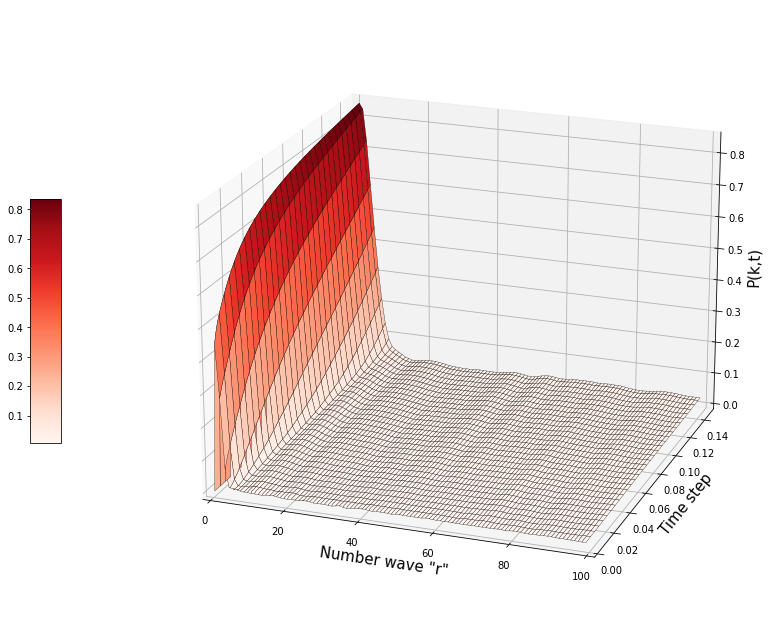

In [23]:
plot_correlations_3d('cc', 0.15, dt, 20, 290)

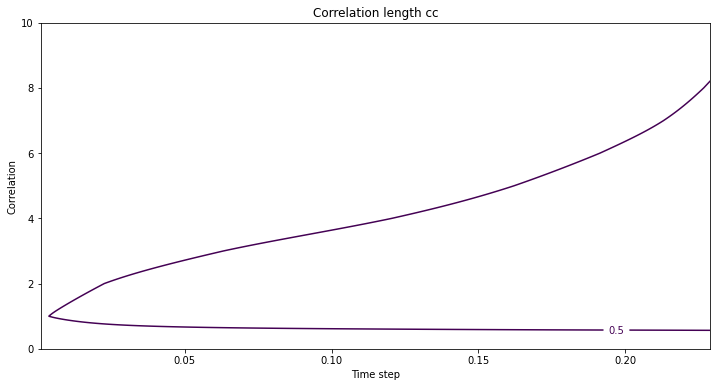

In [38]:
plot_contour('cc', T, dt, y_max=10)

In [30]:
t = dt
while t < T:
    polar_mean(t, "ss")
    # axis_mean(t, "ss")
    t += dt

In [31]:
# plot_correlations_3d('ss', 0.15, dt, 20, 290)

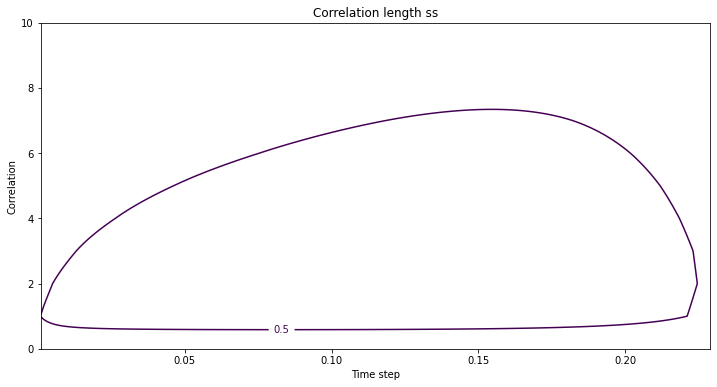

In [39]:
plot_contour('ss', T, dt, y_max=10)

In [ ]:
t = dt
while t < T:
    polar_mean(t, "ii")
    # axis_mean(t, "ii")
    t += dt

In [34]:
# plot_correlations_3d('ii', T, dt, 20, 290)

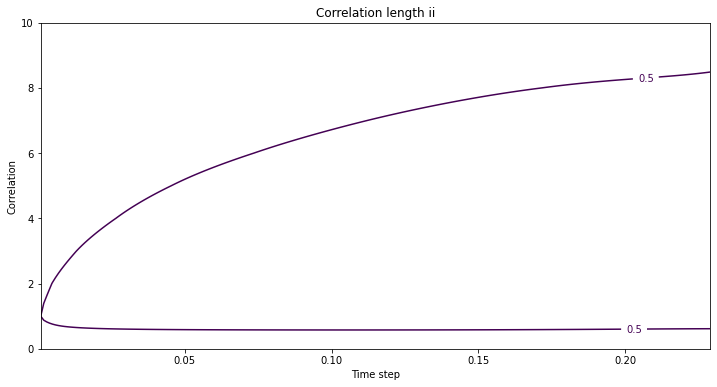

In [45]:
plot_contour('ii', T, dt, y_max=10)

In [47]:
t = dt
while t < T:
    polar_mean(t, "cs")
    # axis_mean(t, "cs")
    t += dt

In [48]:
# plot_correlations_3d('cs', 0.15, dt, 20, 290)

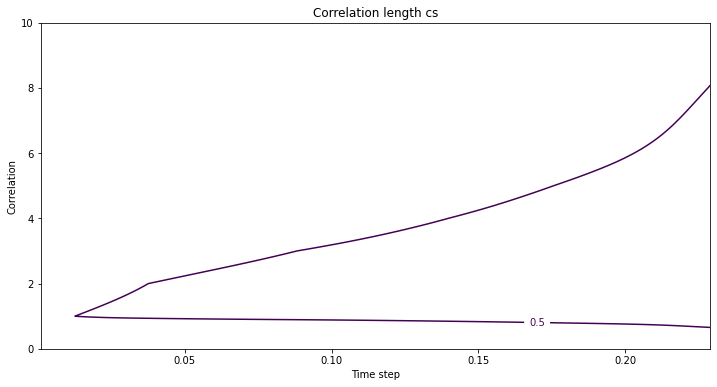

In [49]:
plot_contour('cs', T, dt, y_max=10)

In [53]:
t = dt
while t < T:
    polar_mean(t, "ci")
    # axis_mean(t, "ci")
    t += dt

In [51]:
# plot_correlations_3d('ci', T, dt, 20, 290)

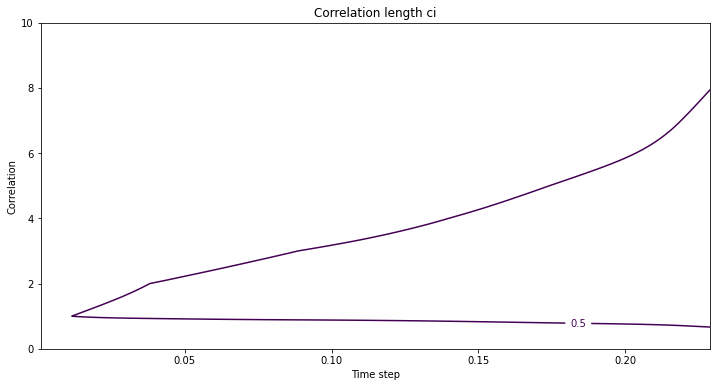

In [54]:
plot_contour('ci', T, dt, y_max=10)

In [55]:
t = dt
while t < T:
    polar_mean(t, "si")
    # axis_mean(t, "si")
    t += dt

In [56]:
# plot_correlations_3d('si', T, dt, 20, 290)

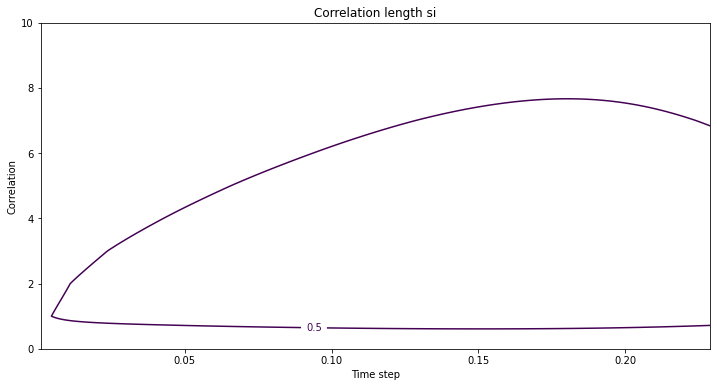

In [58]:
plot_contour('si', T, dt, y_max=10)

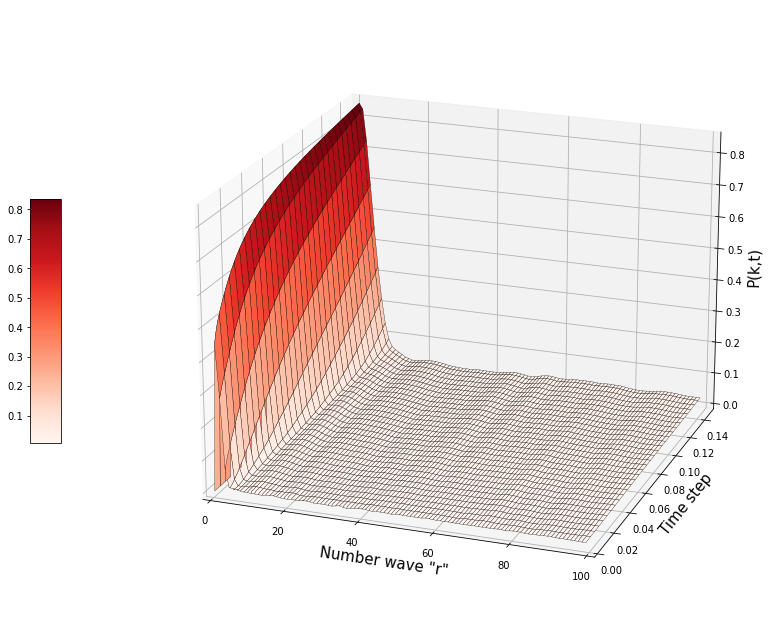

In [24]:
plot_correlations_3d('cc', 0.15, dt, 20, 290)

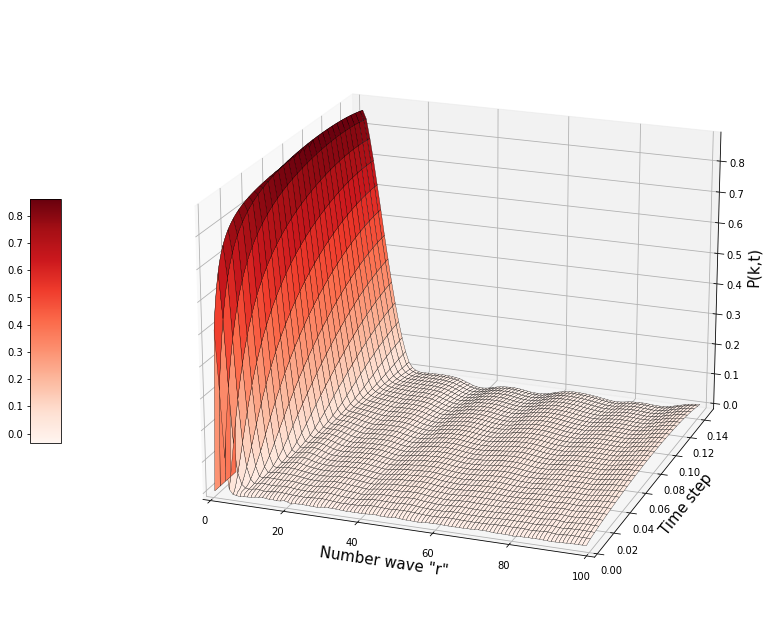

In [25]:
plot_correlations_3d('ss', 0.15, dt, 20, 290)

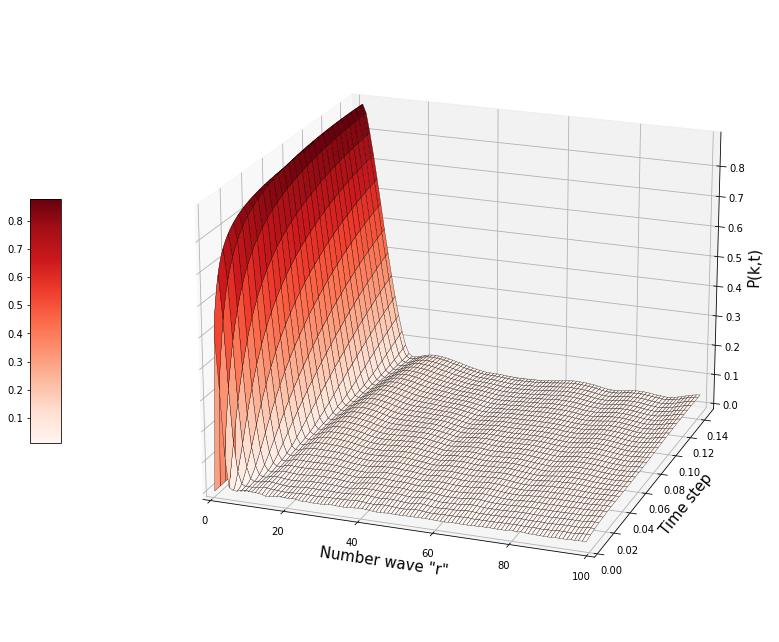

In [26]:
plot_correlations_3d('ii', 0.15, dt, 20, 290)

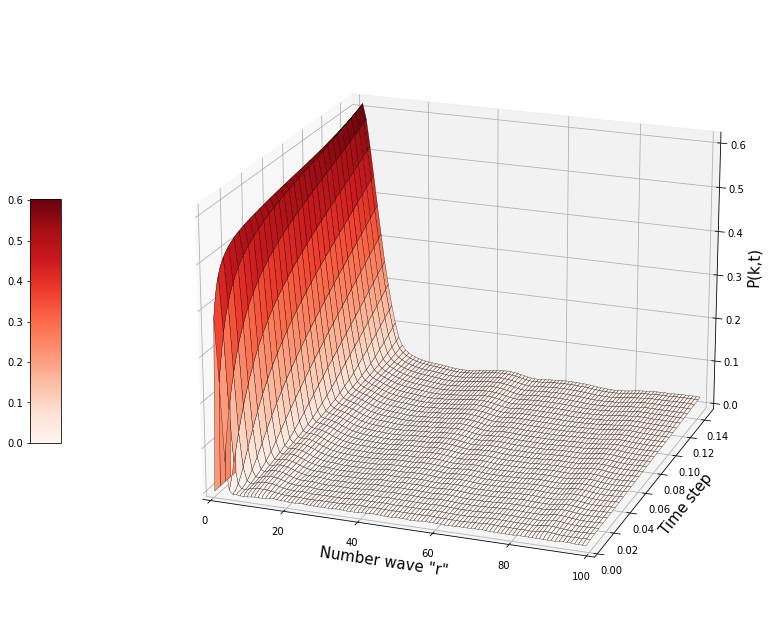

In [27]:
plot_correlations_3d('cs', 0.15, dt, 20, 290)

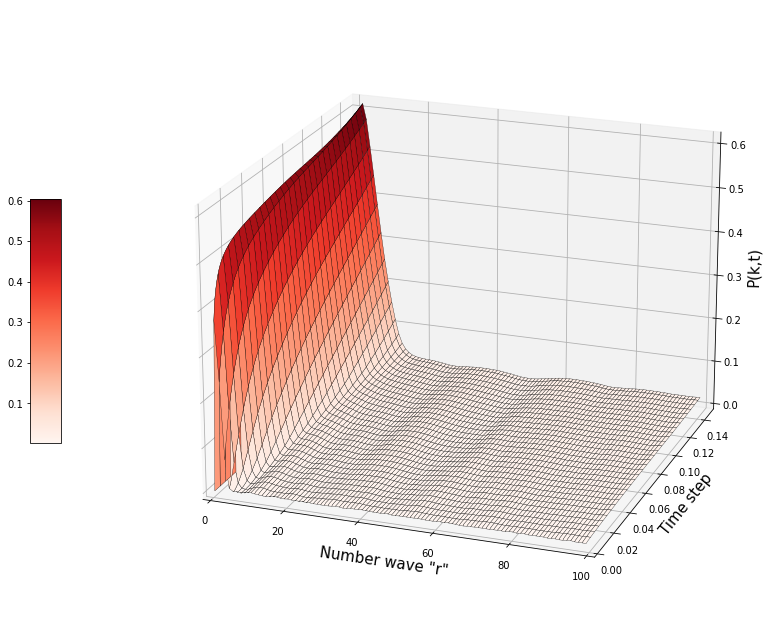

In [28]:
plot_correlations_3d('ci', 0.15, dt, 20, 290)

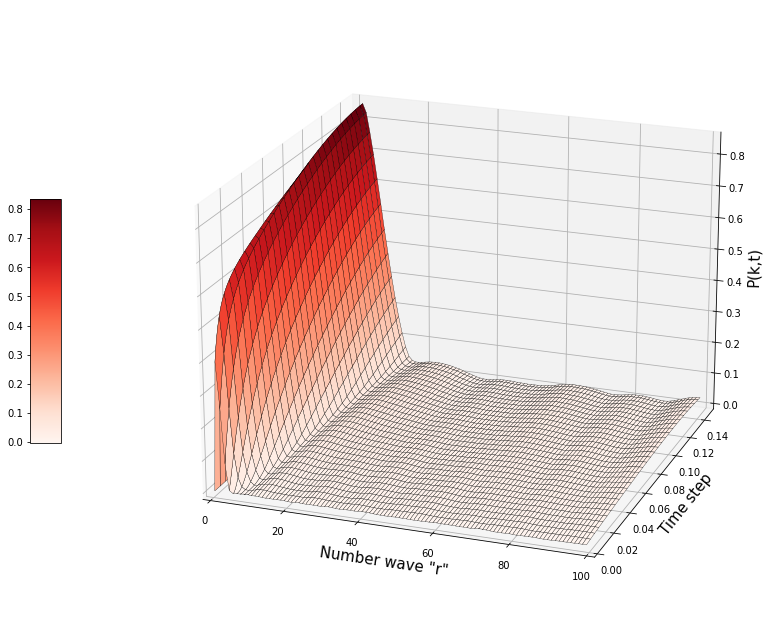

In [29]:
plot_correlations_3d('si', 0.15, dt, 20, 290)